In [1]:
import os
import re

import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity
from torch.utils.data import DataLoader, Dataset


In [2]:
root_data_folder = "/projects/SkyGAN/clouds_fisheye"
desc_file = "processed_1K_JPGs.txt"

In [3]:
# Get all paths to .jpg images
def get_paths_list(root_data_folder, desc_file):
    file_path = os.path.join(root_data_folder, desc_file)

    with open(file_path) as f:
        paths = f.read().strip().split('\n')
        paths = list(map(lambda x: os.path.join(root_data_folder, x), paths))

    return paths

In [4]:
paths_list = get_paths_list(root_data_folder, desc_file)
f"Number of images: {len(paths_list)}"

'Number of images: 18840'

In [5]:
# Separating images in different folders
def image_paths_to_dict(paths):
    locations_map = {}
    for path in paths:
        full_path, file = os.path.split(path)
        if full_path in locations_map:
            locations_map[full_path].append(file)
        else:
            locations_map[full_path] = [file]
    return locations_map

In [6]:
locations_map = image_paths_to_dict(paths_list)
f"Number of folders: {len(locations_map)}"

'Number of folders: 61'

In [7]:
# Sort images in locations_map by number in the filename
def extract_number(file_name):
    match = re.search(r'_(\d+)\.', file_name)
    if match:
        return int(match.group(1))
    return 0
    
for path in locations_map:
    locations_map[path] = sorted(locations_map[path], key=extract_number)

In [8]:
# Get most commmon offset between filenames in the list of paths
def get_most_common_offset(filenames):
    offsets = {}
    for i in range(len(filenames) - 1):
        current = extract_number(filenames[i])
        next = extract_number(filenames[i + 1])
        if (next - current) in offsets:
            offsets[(next - current)] += 1
        else:
            offsets[(next - current)] = 1

    max_offset = max(offsets, key = lambda x: offsets[x])
    return max_offset

In [9]:
# Split lists into multiple lists based on the most common offset 
def split_lists(locations_map):
    res_dict = {}
    for path in locations_map:
        offset = get_most_common_offset(locations_map[path])
        
        prev_number = extract_number(locations_map[path][0])
        main_list = []
        temp_list = [locations_map[path][0]]
        
        for i in range(1, len(locations_map[path])):
            order_number = extract_number(locations_map[path][i])
            if (order_number - prev_number) == offset:
                temp_list.append(locations_map[path][i])
            else:
                main_list.append(temp_list)
                temp_list = [locations_map[path][i]]
            prev_number = order_number
        if temp_list:
            main_list.append(temp_list)
        res_dict[path] = main_list
        
    return res_dict

In [10]:
splitted_locations_map = split_lists(locations_map)

In [11]:
# Get lists with sequential images 
def get_lists(splitted_locations_map):
    res = []
    for root_path in splitted_locations_map:
        for seq in splitted_locations_map[root_path]:
            if len(seq) > 1:
                res.append(list(map(lambda x: os.path.join(root_path, x), seq)))
    return res

In [12]:
sequential_paths = get_lists(splitted_locations_map)

In [13]:
def image_similarity(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    score, _ = structural_similarity(img1_gray, img2_gray, full=True)

    return score

In [14]:
def plot_neighboring_ssim(neighboring_similarities, ind):
    plt.clf()
    indices = list(range(1, len(neighboring_similarities) + 1))
    plt.plot(indices, neighboring_similarities)
    plt.title('Structural Similarity Index Measure Plot')
    plt.xlabel('Image Pair Index')
    plt.ylabel('SSIM Value')
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.savefig(f"ssims/{ind}.png")

In [15]:
def calculate_and_show_ssim(sequential_paths):
    all_similarities = []
    for j, seq in enumerate(sequential_paths):
        neighboring_similarities = []
        for i in range(len(seq) - 1):
            neighboring_similarities.append(image_similarity(seq[i], seq[i + 1]))
        # plot_neighboring_ssim(neighboring_similarities, j)
        # all_similarities.append(neighboring_similarities)
        print(f"index: {j}; len: {len(seq)}; min ssim: {min(neighboring_similarities)}; avg ssim: {sum(neighboring_similarities) / len(neighboring_similarities)}")
    return all_similarities

In [ ]:
calculate_and_show_ssim(sequential_paths)

index: 0; len: 476; min ssim: 0.9837638474478702; avg ssim: 0.9883305699119082
index: 1; len: 355; min ssim: 0.968635229326814; avg ssim: 0.9883734464075407
index: 2; len: 15; min ssim: 0.7948987356185543; avg ssim: 0.8409407375306122
index: 3; len: 86; min ssim: 0.7221242999021671; avg ssim: 0.7742644792802975
index: 4; len: 421; min ssim: 0.8042870729124366; avg ssim: 0.9174186336796417
index: 5; len: 28; min ssim: 0.6031715925650102; avg ssim: 0.7899462161953624
index: 6; len: 14; min ssim: 0.8523675512224838; avg ssim: 0.8559655682906139
index: 7; len: 492; min ssim: 0.9025716161399527; avg ssim: 0.9768291440519741
index: 8; len: 220; min ssim: 0.9377510275255079; avg ssim: 0.9817378094545908
index: 9; len: 226; min ssim: 0.8544087747991707; avg ssim: 0.9809487729483506
index: 10; len: 22; min ssim: 0.9783557957967107; avg ssim: 0.9817655912949796
index: 11; len: 380; min ssim: 0.8931067292445048; avg ssim: 0.9403394053450027
index: 12; len: 526; min ssim: 0.8322110310868428; avg s

In [27]:
class SkyDataset(Dataset):
    def __init__(self, root_data_folder="/projects/SkyGAN/clouds_fisheye", desc_file="processed_1K_JPGs.txt", transform=None, seq_len=2, offset=5):
        self._root_data_folder = root_data_folder
        self._desc_file = desc_file
        
        image_path_list = self._get_image_paths()
        image_path_dict = self._image_paths_to_dict(image_path_list)
        image_seq_splitted_dict = self._split_lists(image_path_dict)
        image_seq_splitted_list = self._get_lists(image_seq_splitted_dict)
        self._image_path_list = self._seq_to_pairs(image_seq_splitted_list, seq_len, offset)

        
        self._n_samples = len(self._image_path_list)
        
        self._transform = transform

    def _extract_number(self, file_name):
        match = re.search(r'_(\d+)\.', file_name)
        if match:
            return int(match.group(1))
        return 0

    def _get_image_paths(self):
        file_path = os.path.join(self._root_data_folder, self._desc_file)
        try:
            with open(file_path) as f:
                paths = f.read().strip().split('\n')
                paths = list(map(lambda x: os.path.join(self._root_data_folder, x), paths))
            return paths
        except FileNotFoundError:
            raise FileNotFoundError(f"Could not find file {self._desc_file} enumerating all image paths")
        except IOError:
            raise IOError(f"An IOError occured while reading file {file_path}. Check correctness of the contents")

    def _image_paths_to_dict(self, paths):
        locations_map = {}
        for path in paths:
            full_path, file = os.path.split(path)
            if full_path in locations_map:
                locations_map[full_path].append(file)
            else:
                locations_map[full_path] = [file]
                
        for path in locations_map:
            locations_map[path] = sorted(locations_map[path], key=self._extract_number)
            
        return locations_map

    def _get_most_common_offset(self, filenames):
        offsets = {}
        for i in range(len(filenames) - 1):
            current = self._extract_number(filenames[i])
            next = self._extract_number(filenames[i + 1])
            if (next - current) in offsets:
                offsets[(next - current)] += 1
            else:
                offsets[(next - current)] = 1
    
        max_offset = max(offsets, key = lambda x: offsets[x])
        return max_offset

    def _split_lists(self, locations_map):
        res_dict = {}
        for path in locations_map:
            offset = self._get_most_common_offset(locations_map[path])
            
            prev_number = self._extract_number(locations_map[path][0])
            main_list = []
            temp_list = [locations_map[path][0]]
            
            for i in range(1, len(locations_map[path])):
                order_number = self._extract_number(locations_map[path][i])
                if (order_number - prev_number) == offset:
                    temp_list.append(locations_map[path][i])
                else:
                    main_list.append(temp_list)
                    temp_list = [locations_map[path][i]]
                prev_number = order_number
            if temp_list:
                main_list.append(temp_list)
            res_dict[path] = main_list
            
        return res_dict

    def _get_lists(self, splitted_locations_map):
        res = []
        for root_path in splitted_locations_map:
            for seq in splitted_locations_map[root_path]:
                if len(seq) > 1:
                    res.append(list(map(lambda x: os.path.join(root_path, x), seq)))
        return res

    def _seq_to_pairs(self, sequential_paths, seq_len, offset=10):
        res = []
        for seq in sequential_paths:
            if len(seq) < seq_len:
                continue

            for i in range(len(seq) - (offset) * (seq_len - 1)):
                tmp = []
                for j in range(0, offset * seq_len, offset):
                    tmp.append(seq[i + j])
                res.append(tmp)
        return res

    def __getitem__(self, item):
        images = [Image.open(img) for img in self._image_path_list[item]]

        if self._transform:
            images = [self._transform(img) for img in images]

        return torch.cat(images[:-1]), images[-1]

    def __len__(self):
        return len(self._image_path_list)

In [16]:
sd = SkyDataset()

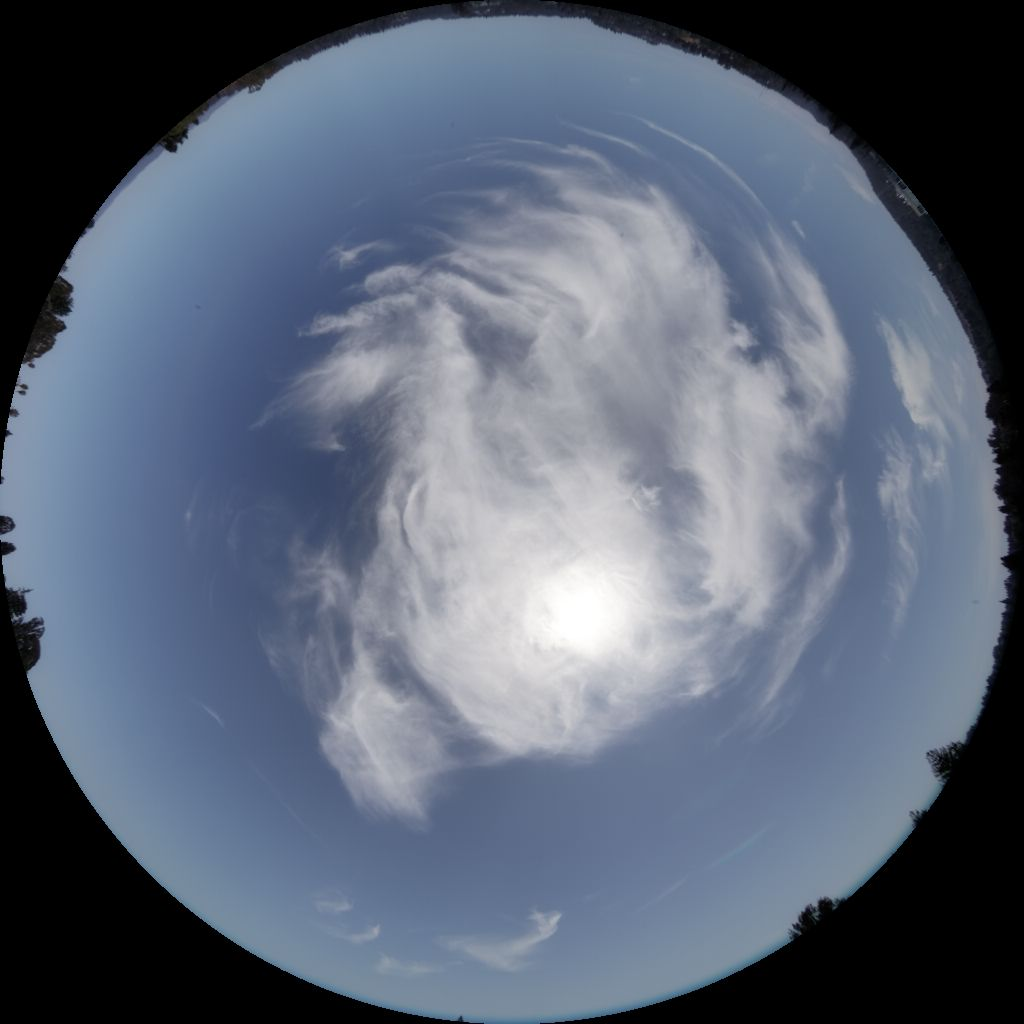

In [25]:
sd[4000][0]

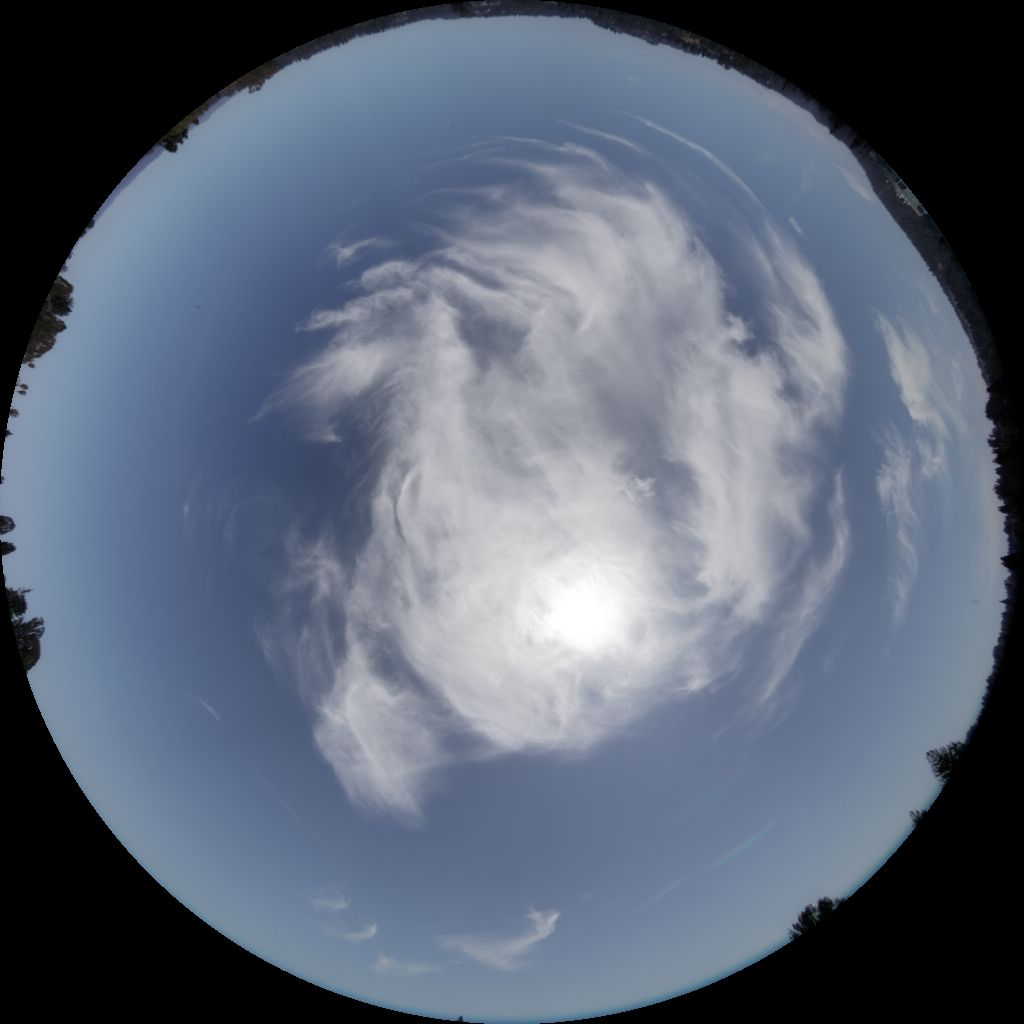

In [26]:
sd[4000][1]